<a href="https://colab.research.google.com/github/PratikshitSingh/Algotrading/blob/master/ps_Dark_Pool_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dark pool execution using an epsilon-greedy agent

#### The concept of the multi-armed bandit problem can be seen when executing in dark pools. It is difficult to gain historical data or insight into there environment, thus data can only be collected by exploring.

#### Unfortunely, we do not have access to the trade prices of individual dark pools. In an ideal world, we would execute trades in dark pools, save trade statistics in a database, and use implementation shortfall in our analysis.

#### Luckily, FINRA offers a free dataset of total shares traded on many dark pools for equity securities.

https://otctransparency.finra.org/otctransparency/AtsData


In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import json
import warnings
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
from collections import defaultdict
warnings.filterwarnings("ignore")

In [ ]:
ticker = 'TSLA'

url = 'https://api.finra.org/data/group/otcmarket/name/weeklySummary'

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  }

customFilter = {
  "limit" : 5000,
  "compareFilters": [
      {"compareType": "equal", 
        "fieldName": "issueSymbolIdentifier", 
        "fieldValue" : f"{ticker}"}
  ]
}

# Make a GET request for ATS data from FINRA (weekly data)
request = requests.post(url, headers=headers, json=customFilter)

# Convert result from GET request to dataframe
df = pd.DataFrame(request.json())
df = df[df['summaryTypeCode'] =='ATS_W_SMBL_FIRM']
df['averageTradeSize'] = (df['totalWeeklyShareQuantity'] / df['totalWeeklyTradeCount']).apply(np.floor).astype(int)
df = df[['MPID', 'totalWeeklyShareQuantity', 'totalWeeklyTradeCount', 'averageTradeSize', 'summaryTypeCode','weekStartDate']]
df['weekStartDate'] = pd.to_datetime(df['weekStartDate'])
df.tail(5)

,MPID,totalWeeklyShareQuantity,totalWeeklyTradeCount,averageTradeSize,summaryTypeCode,weekStartDate
4993,XSTM,214810,836,256,ATS_W_SMBL_FIRM,2021-05-17
4994,LQNA,2400,1,2400,ATS_W_SMBL_FIRM,2021-05-17
4997,UBSA,3380332,103831,32,ATS_W_SMBL_FIRM,2021-05-17
4998,JPMX,705508,13087,53,ATS_W_SMBL_FIRM,2021-05-17
4999,JPBX,77532,2998,25,ATS_W_SMBL_FIRM,2021-05-17


In [ ]:
# This cell fills any trading gaps a dark pool may have.
# A less popular dark pool may only occasionally trade a specific security.
# For our problem, we need data for each week, thus we fill missing weeks with dummy data. 

dark_pools = set(df["MPID"])
all_dates = list(set(df['weekStartDate']))

append_df = pd.DataFrame()
append_dict = dict.fromkeys(list(df.columns), [])

for date in all_dates:
    cur_df = df[df['weekStartDate'] == date]
    cur_MPIDs = set(cur_df['MPID'])
    remainder_MPIDs = list(dark_pools - cur_MPIDs)
    len_remainder = len(remainder_MPIDs)
    if len_remainder == 0: 
        continue
    append_dict['MPID'] = append_dict['MPID'] + remainder_MPIDs
    append_dict['totalWeeklyShareQuantity'] = append_dict['totalWeeklyShareQuantity'] + [0 for x in range(0, len_remainder)]
    append_dict['totalWeeklyTradeCount'] = append_dict['totalWeeklyTradeCount'] + [0 for x in range(0, len_remainder)]
    append_dict['averageTradeSize'] = append_dict['averageTradeSize'] + [0 for x in range(0, len_remainder)]
    append_dict['summaryTypeCode'] = append_dict['summaryTypeCode'] + ['ATS_W_SMBL_FIRM' for x in range(0, len_remainder)]
    append_dict['weekStartDate'] = append_dict['weekStartDate'] + [date for x in range(0, len_remainder)]
    
append_df = pd.DataFrame(append_dict)

frames = [df, append_df] 
df = pd.concat(frames)

In [ ]:
# Problem: We want to submit an order to buy 500 shares of TSLA in one block. Which dark pools will our order fill assuming no partial fills.
# in order for your trade to execute, the dark pool must atleast have an average trade size of 500 and cross 2 or more trades. 
# (In a real world scenario, your order could easily be broken up and distributed to many dark pools, exchanges, or over-the-counter)

df['filled'] = np.where((df['averageTradeSize'] >= 500) & (df['totalWeeklyTradeCount'] >= 2), True, False)
df[df['filled'] == True]

,MPID,totalWeeklyShareQuantity,totalWeeklyTradeCount,averageTradeSize,summaryTypeCode,weekStartDate,filled
16,BIDS,664428,428,1552,ATS_W_SMBL_FIRM,2022-12-12,True
17,MSTX,841000,1202,699,ATS_W_SMBL_FIRM,2022-12-12,True
31,LQNA,73400,10,7340,ATS_W_SMBL_FIRM,2022-12-12,True
45,BLKX,85460,15,5697,ATS_W_SMBL_FIRM,2022-12-12,True
58,BIDS,1203504,822,1464,ATS_W_SMBL_FIRM,2022-11-07,True
...,...,...,...,...,...,...,...
4812,BLKX,10000,2,5000,ATS_W_SMBL_FIRM,2021-04-05,True
4906,XIST,2471,2,1235,ATS_W_SMBL_FIRM,2021-04-19,True
4922,BIDS,33300,66,504,ATS_W_SMBL_FIRM,2021-04-19,True
4951,BLKX,26379,3,8793,ATS_W_SMBL_FIRM,2020-03-09,True


In [ ]:
# We organized our data so that each dark pool has its own column with rows displaying the execution status of your trade.

dark_pool_df = df[['MPID', 'filled', 'weekStartDate']]
dark_pool_df['weekStartDate'] = dark_pool_df['weekStartDate'].apply(lambda x: x.value)
dark_pool_df = dark_pool_df.set_index('weekStartDate')
dark_pool_df = dark_pool_df.pivot_table(values='filled', index=dark_pool_df.index, columns='MPID', aggfunc='first').reset_index().drop(columns=['weekStartDate'])
dark_pool_df.head(5)

MPID,AQUA,BIDS,BLKX,BLUE,BNPX,CBLC,CGXS,CODA,CROS,DBAX,...,MSTX,ONEC,PJCX,PURE,SGMT,STFX,UBSA,USTK,XIST,XSTM
0,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
class DarkPoolFillsLog:
    def __init__(self):
        self.total_actions = 0
        self.total_rewards = 0
        self.all_rewards = []
        self.logs = defaultdict(lambda: dict(actions=0, reward=0))

    def track_outcome(self, dark_pool, reward):
        self.total_actions += 1
        self.total_rewards += reward
        self.all_rewards.append(reward)
        self.logs[dark_pool]['actions'] += 1
        self.logs[dark_pool]['reward'] += reward

    def get_logs(self, dark_pool):
        return self.logs[dark_pool]

In [ ]:
class EpsilonGreedyAlgorithm:
    def __init__(self, dark_pools_df, epsilon=None, epsilon_decay=False, trace=False):
        self.dark_pools = dark_pools_df
        self.dark_pools_names = list(dark_pools_df.columns)
        self.epsilon = epsilon
        self.fills_log = DarkPoolFillsLog()
        self.epsilon_decay = epsilon_decay
        self.trace = trace

    def get_random_dark_pool(self):
        return np.random.choice(self.dark_pools_names)

    def get_current_best_dark_pool(self):
        estimates = []
        for pool in self.dark_pools_names:
            dark_pool_record = self.fills_log.get_logs(pool)
            if not dark_pool_record['actions']:
                estimates.append(0)
            else:
                estimates.append(dark_pool_record['reward'] / dark_pool_record['actions'])
               
        estimates = np.array(estimates)
        return self.dark_pools_names[np.random.choice(np.flatnonzero(estimates == estimates.max()))]

    def explore_or_exploit(self, cur_index):
        epsilon = self.epsilon or 1 / (1 + self.fills_log.total_actions)

        p = np.random.uniform(0, 1, 1)
        if p < epsilon:
            dark_pool = self.get_random_dark_pool()
            if self.trace: print("Getting random dark pool: " + dark_pool)
        else:
            dark_pool = self.get_current_best_dark_pool()
            if self.trace: print("Getting best dark pool: " + dark_pool)

        return dark_pool

    def epsilon_greedy_iteration(self, cur_index):
        current_dark_pool = self.explore_or_exploit(cur_index)
        reward = int(self.dark_pools[current_dark_pool].iloc[cur_index])
        self.fills_log.track_outcome(current_dark_pool, reward)
        return reward

    def take_actions(self, iterations):
        for x in range(iterations):
            self.epsilon_greedy_iteration(x)

            if self.epsilon_decay and x%10 == 0 and self.epsilon >= 0:
                self.epsilon -= 0.05
                if self.trace: print(self.epsilon)

In [ ]:
def plot_results(agents, rewards, test_epsilons):
  for i in range(len(agents)):
    plt.plot(np.cumsum(rewards[i]), label=f"epsilon = {test_epsilons[i]}")

  plt.xlabel("iteration")
  plt.ylabel("total fills")
  plt.legend()
  plt.show()

In [ ]:
dark_pool_df = dark_pool_df.sample(frac=1).reset_index(drop=True)

In [ ]:
algo = EpsilonGreedyAlgorithm(dark_pools_df=dark_pool_df, epsilon=0.2, trace=False)
algo.take_actions(len(dark_pool_df.index))

In [ ]:
sum(algo.fills_log.all_rewards)

33

In [ ]:
algo.fills_log.logs

defaultdict(<function __main__.DarkPoolFillsLog.__init__.<locals>.<lambda>()>,
            {'AQUA': {'actions': 2, 'reward': 0},
             'BIDS': {'actions': 1, 'reward': 0},
             'BLKX': {'actions': 1, 'reward': 0},
             'BLUE': {'actions': 0, 'reward': 0},
             'BNPX': {'actions': 1, 'reward': 0},
             'CBLC': {'actions': 1, 'reward': 0},
             'CGXS': {'actions': 1, 'reward': 0},
             'CODA': {'actions': 0, 'reward': 0},
             'CROS': {'actions': 0, 'reward': 0},
             'DBAX': {'actions': 1, 'reward': 0},
             'EBXL': {'actions': 1, 'reward': 0},
             'IATS': {'actions': 0, 'reward': 0},
             'ICBX': {'actions': 1, 'reward': 0},
             'INCR': {'actions': 0, 'reward': 0},
             'ITGP': {'actions': 1, 'reward': 0},
             'JPBX': {'actions': 2, 'reward': 0},
             'JPMX': {'actions': 0, 'reward': 0},
             'KCGM': {'actions': 0, 'reward': 0},
             'LATS': 

In [ ]:
test_epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45, 0.5]
algos = []

for epsilon in test_epsilons:
    print(f"Running epsilon-greedy for epsilon = {epsilon}")
    algo = EpsilonGreedyAlgorithm(dark_pools_df=dark_pool_df, epsilon=epsilon)
    algo.take_actions(len(dark_pool_df.index))
    algos.append(algo)
    
all_rewards = [algo.fills_log.all_rewards for algo in algos]

Running epsilon-greedy for epsilon = 0.05
Running epsilon-greedy for epsilon = 0.1
Running epsilon-greedy for epsilon = 0.15
Running epsilon-greedy for epsilon = 0.2
Running epsilon-greedy for epsilon = 0.25
Running epsilon-greedy for epsilon = 0.3
Running epsilon-greedy for epsilon = 0.45
Running epsilon-greedy for epsilon = 0.5


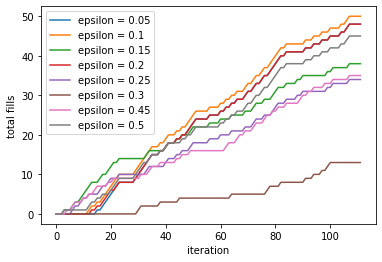

In [ ]:
plot_results(algos, all_rewards, test_epsilons)

In [ ]:
algos = []

for epsilon in test_epsilons:
    print(f"Running epsilon-greedy for epsilon = {epsilon}")
    algo = EpsilonGreedyAlgorithm(dark_pools_df=dark_pool_df, epsilon=epsilon, epsilon_decay=True)
    algo.take_actions(len(dark_pool_df.index))
    algos.append(algo)
    
all_rewards = [algo.fills_log.all_rewards for algo in algos]

Running epsilon-greedy for epsilon = 0.05
Running epsilon-greedy for epsilon = 0.1
Running epsilon-greedy for epsilon = 0.15
Running epsilon-greedy for epsilon = 0.2
Running epsilon-greedy for epsilon = 0.25
Running epsilon-greedy for epsilon = 0.3
Running epsilon-greedy for epsilon = 0.45
Running epsilon-greedy for epsilon = 0.5


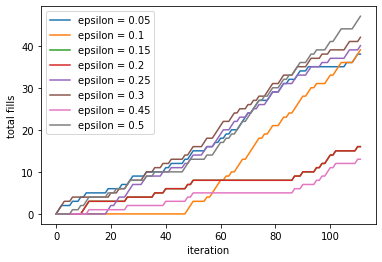

In [ ]:
plot_results(algos, all_rewards, test_epsilons)